In [ ]:
import json
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from geometry import computeCameraCalibration

import warnings
warnings.filterwarnings('ignore')

# VPs


"vid_main.mp4"

{"vp1": [388.9230769230769, 127.26153846153846], "vp2": [-59.381443298969074, 79.83505154639175], "pp": [176.5, 320.5]}}




In [ ]:
with open('output_calib_vid_mask', 'r+') as file:
    structure = json.load(file)
    camera_calibration = structure['camera_calibration']

In [ ]:
vp1, vp2, vp3, pp , roadPlane, focal = computeCameraCalibration(camera_calibration["vp1"],
                                                  camera_calibration["vp2"],
                                                  camera_calibration["pp"])
print("First VP: ", vp1)
print("Second VP: ", vp2)
print("Third VP: ", vp3)
print("Principal Point: ", pp)
print("Road Plane: ", roadPlane)
print("Focal point: ", focal)

First VP:  [400.61068702 115.54198473   1.        ]
Second VP:  [-52.24489796  79.02040816   1.        ]
Third VP:  [175.85961538 328.44055955   1.        ]
Principal Point:  [176.5 320.5   1. ]
Road Plane:  [-0.01495157  0.18539451  0.98255042 10.        ]
Focal point:  42.083231390082126


In [ ]:
img = cv2.imread("first_vid_main.png")
type(img)

numpy.ndarray

In [ ]:
img.shape

(640, 352, 3)

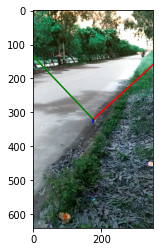

In [ ]:
plt.plot([pp[0],vp1[0]], [pp[1],vp1[1]], 'r-', 6)
plt.plot([pp[0],vp2[0]],[pp[1], vp2[1]], 'g-', 6)
plt.plot([pp[0],vp3[0]], [pp[1],vp3[1]], 'b-', 6)
plt.imshow(img)
plt.show()

# File Analysis

In [ ]:
# Get Angles from main video
with open('testvid_main.txt', 'r+') as file:
    structure = json.load(file)
    angles = structure['angles']

print('min theta: ',min(angles))
print('max theta: ',max(angles))

# sns.distplot(angles);

min theta:  -154.822
max theta:  -168.289


In [ ]:
# Get Angles from left shifted video
with open('testvid_left.txt', 'r+') as file:
    structure = json.load(file)
    angles_left = structure['angles']

print('min theta: ',min(angles_left))
print('max theta: ',max(angles_left))

# sns.distplot(angles_left);

min theta:  -138.49
max theta:  -160.307


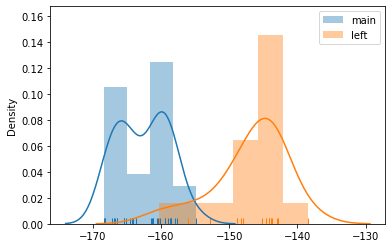

In [ ]:
# Plot the angles to see comparison
sns.distplot(angles, rug = True, label= 'main');
sns.distplot(angles_left, rug = True, label = 'left');
plt.legend()
plt.show()

# Mask Creation

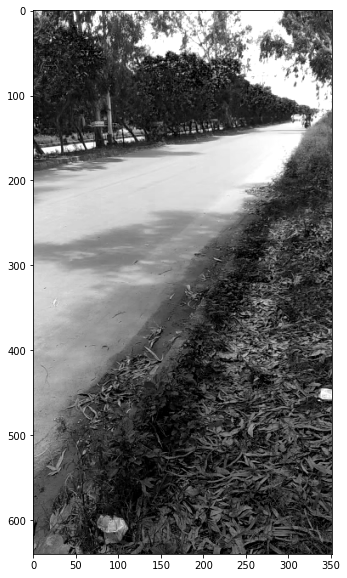

In [ ]:
img = cv2.imread('first_vid_main.png')
plt.figure(figsize = (10,10))
plt.imshow(img[:,:,0], cmap = 'gray')
plt.show()

In [ ]:
img.shape

(640, 352, 3)

In [ ]:
# Create a zero array
stencil = np.zeros_like(img[:,:,0])

# specify coordinates of polygon
polygon = np.array([[0, 640],[50,640],[352,115],[320,115],[0,180]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)

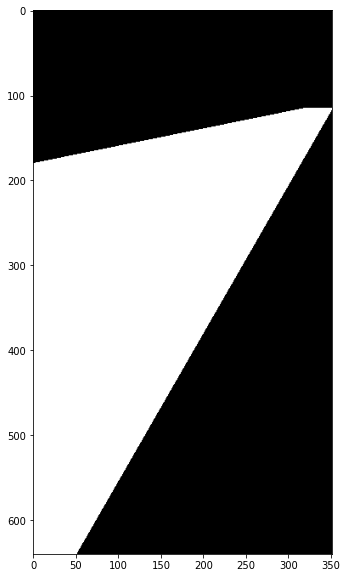

In [ ]:
# plot polygon
plt.figure(figsize= (10,10))
plt.imshow(stencil, cmap ='gray')
plt.show()

In [ ]:
# Apply polygon as a mask on the frame/road img
img_after_mask = cv2.bitwise_and(img, img, mask = stencil)

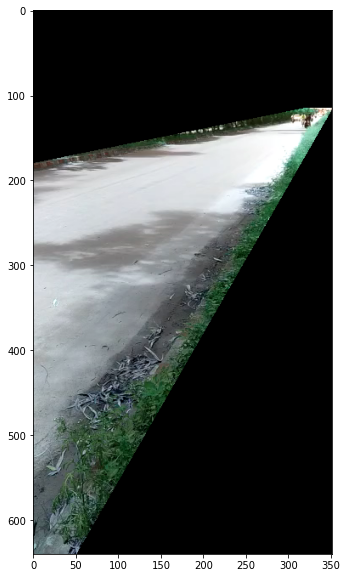

In [ ]:
# Plot masked image
plt.figure(figsize = (10,10))
plt.imshow(img_after_mask, cmap = 'gray')
plt.show()

In [ ]:
# Apply mask on video
cap = cv2.VideoCapture('vid_main.mp4')

In [ ]:
fps = cap.get(cv2.CAP_PROP_FPS)
fps

30.34089032132375

In [ ]:
total = cap.get(cv2.CAP_PROP_FRAME_COUNT)
total

796.0

In [ ]:
frame_count = 0
final_frames = []
while (frame_count < total-1):
  frame_count += 1
  ret, frame = cap.read()
  frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
  # Apply polygon as a mask on the frame
  frame_after_mask = cv2.bitwise_and(frame, frame, mask = stencil)
  final_frames.append(frame_after_mask)

In [ ]:
def convert_frames_to_video(frames, output_video_path):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
    height, width, channels = frames[0].shape
    out = cv2.VideoWriter(output_video_path, fourcc,15, (width, height))
    for i, ff in enumerate (frames):
        out.write(ff)

In [ ]:
len(final_frames)

795

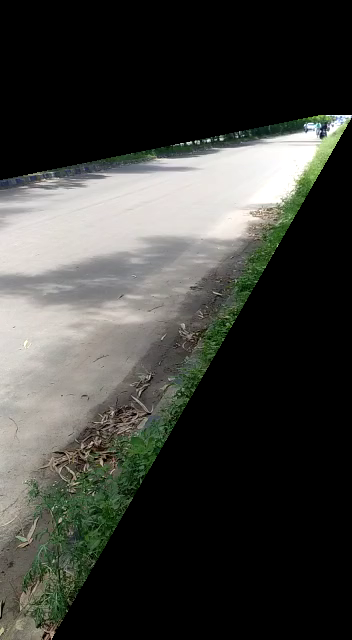

In [ ]:
cv2_imshow(final_frames[0])

In [ ]:
convert_frames_to_video(final_frames, 'vid_main_mask.mp4')

In [ ]:
cap2 = cv2.VideoCapture('vid_main_mask.mp4')
cap2.get(cv2.CAP_PROP_FRAME_COUNT)

795.0

# ransac

In [ ]:
from estimateVP import VanishingPoints

In [ ]:
getvp = VanishingPoints('vid_main_mask.mp4')

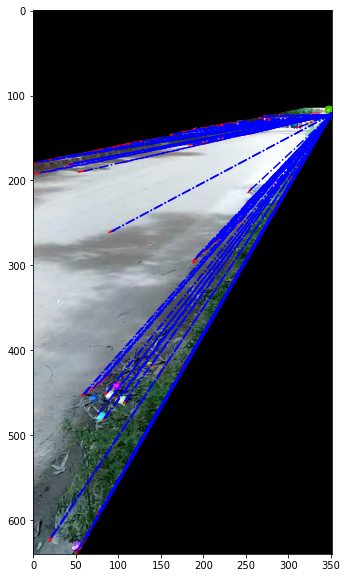

In [ ]:
vp1,edgelets1,img = getvp.first_vp()

In [ ]:
vp1

array([350.45121921, 122.47494683,   1.        ])

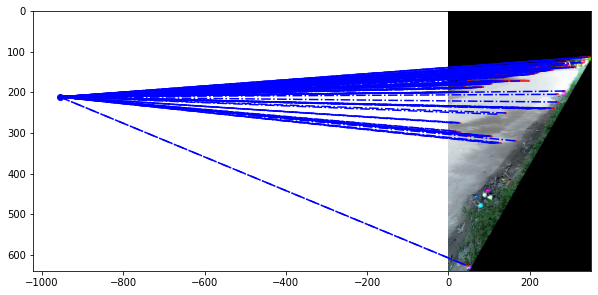

In [ ]:
vp2,_ = getvp.second_vp(vp1, edgelets1, img)

In [ ]:
vp2

array([-956.80090865,  211.41025005,    1.        ])

In [ ]:
roadimg = cv2.imread('first_vid_main.png')

In [ ]:
roadimg.shape

(640, 352, 3)

In [ ]:
pp 

array([176.5, 320.5,   1. ])

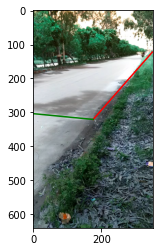

In [ ]:
plt.plot([pp[0],vp1[0]], [pp[1],vp1[1]], 'r-', 6)
plt.plot([pp[0],vp2[0]],[pp[1], vp2[1]], 'g-', 6)
# plt.plot([pp[0],vp3[0]], [pp[1],vp3[1]], 'b-', 6)
plt.imshow(roadimg)
plt.show()

In [ ]:
video_name = 'test_vid_main_mask.mp4'
json_structure = {'video': [str(video_name)], 
                  "camera_calibration": {"vp1": [350.45121921, 122.47494683],
                                         "vp2": [-956.80090865,  211.41025005],
                                          "pp": [176.5, 320.5]}}
with open('correct_vp.txt', 'w') as file:
    json.dump(json_structure, file)